In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [19]:
from core.quantum_error_correction_code import SurfaceCode, QEC
from core.neural_network import CNNDual, load_params
from core.evaluate_decoder import evaluate_mcnn_decoder, evaluate_pml_decoder

from jax import random
import jax.numpy as jnp
import json

key = random.key(42)

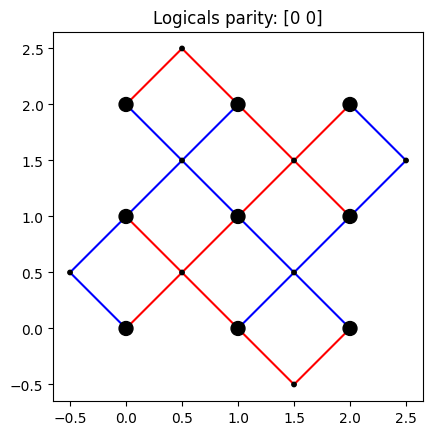

In [3]:
code = SurfaceCode(3)

deformation, key = code.random_deformation(key, jnp.zeros(code.num_data_qubits, dtype=jnp.int32))

parity_info = code.deformation_parity_info(deformation)

code.show(parity_info)

In [4]:
settings, model_params = load_params("data/CNN-G-3.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDual(
    input_shape_1=(1, L+1, L+1),
    input_shape_2=(1, L, L),
    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN_input_1': [(1, 4, 4), (8, 3, 3)],
 'CNN_input_2': [(1, 3, 3), (8, 3, 3)],
 'CNN_stage_2': [(8, 3, 3), (8, 2, 2)],
 'MLP_stage_3': [32, 50, 2]}

# CNN-G decoder

## Random search

In [25]:
def random_search_cnng(
    key,
    code: QEC,
    N: int,
    decoder_model: CNNDual,
    model_params: dict,
    error_probs: dict,
    batch_count: int = 10,
    batch_size: int = 1_000_000,
):
    history = jnp.empty(N, dtype=jnp.float32)
    best_deformation = jnp.empty(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate = jnp.inf
    for i in range(N):
        deformation, key = code.random_deformation(key, allowed_deformations=jnp.arange(6))
        error_rate, _ = evaluate_mcnn_decoder(
            key,
            decoder_model,
            model_params,
            code,
            deformation,
            batch_count,
            batch_size,
            error_probs=error_probs,
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
        history = history.at[i].set(best_error_rate)
    return best_deformation, best_error_rate, history

In [ ]:
R_deformation_cnng_3, R_ler_cnng_3, R_history_cnng_3 = random_search_cnng(
    random.key(42),
    code,
    N=100,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=10,
    batch_size=1_000_000,
)
print(f"Solution \t\t Deformation: {R_deformation_cnng_3} \t Error Rate: {R_ler_cnng_3:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [2 4 2 1 4 1 0 3 0] 	 Error Rate: 3.97E-04		
Iteration 2/100 	 Deformation: [4 4 1 1 4 1 2 4 3] 	 Error Rate: 3.93E-04		
Iteration 3/100 	 Deformation: [4 3 3 5 2 4 4 5 5] 	 Error Rate: 1.41E-04		
Iteration 7/100 	 Deformation: [5 2 3 3 5 1 3 0 4] 	 Error Rate: 1.27E-04		
Iteration 60/100 	 Deformation: [4 5 4 3 4 4 2 1 1] 	 Error Rate: 1.23E-04		
Solution 		 Deformation: [4 5 4 3 4 4 2 1 1] 	 Error Rate: 1.23E-04		47E-04		


## Hill climb search

In [26]:
def hill_climb_search_cnng(
    key,
    code: QEC,
    N: int,
    decoder_model: CNNDual,
    model_params: dict,
    error_probs: dict,
    batch_count: int = 10,
    batch_size: int = 1_000_000,
):
    history = jnp.empty(N, dtype=jnp.float32)
    local_changes = lambda deformation: [
        deformation.at[n].set(d) 
        for n in range(code.num_data_qubits) 
        for d in range(6) 
        if deformation[n] != d
    ]

    best_deformation = jnp.zeros(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate, _ = evaluate_mcnn_decoder(
        key,
        decoder_model,
        model_params,
        code,
        best_deformation,
        batch_count,
        batch_size,
        error_probs=error_probs,
    )
    deformation_candidates = local_changes(best_deformation)
    for i in range(N):
        print(f"Iteration {i+1}/{N}     ", end="\r")
        subkey, key = random.split(key)
        idx = random.randint(subkey, 1, minval=0, maxval=len(deformation_candidates))[0]
        deformation = deformation_candidates[idx]
        error_rate, _ = evaluate_mcnn_decoder(
            key,
            decoder_model,
            model_params,
            code,
            deformation,
            batch_count,
            batch_size,
            error_probs=error_probs,
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
            deformation_candidates = local_changes(best_deformation)
        else:
            deformation_candidates.pop(idx)
            if len(deformation_candidates) == 0:
                print("No more candidates, stopping search.\t\t\t\t\t")
                history = history.at[i:].set(best_error_rate)
                break
        history = history.at[i].set(best_error_rate)
    return best_deformation, best_error_rate, history

In [ ]:
HC_deformation_cnng_3, HC_ler_cnng_3, HC_history_cnng_3 = hill_climb_search_cnng(
    random.key(42),
    code,
    N=100,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=10,
    batch_size=1_000_000,
)
print(f"Solution \t\t Deformation: {HC_deformation_cnng_3} \t Error Rate: {HC_ler_cnng_3:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [0 0 0 0 0 0 0 4 0] 	 Error Rate: 1.32E-03		
Iteration 3/100 	 Deformation: [0 0 4 0 0 0 0 4 0] 	 Error Rate: 8.72E-04		
Iteration 4/100 	 Deformation: [0 0 4 0 0 0 0 3 0] 	 Error Rate: 8.47E-04		
Iteration 5/100 	 Deformation: [0 0 4 0 0 4 0 3 0] 	 Error Rate: 5.81E-04		
Iteration 6/100 	 Deformation: [0 0 4 0 0 4 0 3 4] 	 Error Rate: 3.95E-04		
Iteration 9/100 	 Deformation: [1 0 4 0 0 4 0 3 4] 	 Error Rate: 3.93E-04		
Iteration 12/100 	 Deformation: [1 0 4 0 0 4 1 3 4] 	 Error Rate: 3.89E-04		
Iteration 14/100 	 Deformation: [1 0 4 0 0 2 1 3 4] 	 Error Rate: 2.40E-04		
Iteration 15/100 	 Deformation: [5 0 4 0 0 2 1 3 4] 	 Error Rate: 1.42E-04		
Iteration 17/100 	 Deformation: [5 0 4 0 0 5 1 3 4] 	 Error Rate: 1.37E-04		
Iteration 26/100 	 Deformation: [5 0 4 0 2 5 1 3 4] 	 Error Rate: 1.15E-04		
Iteration 66/100 	 Deformation: [5 0 4 0 2 5 1 1 4] 	 Error Rate: 1.11E-04		
Iteration 71/100 	 Deformation: [3 0 4 0 2 5 1 1 4] 	 Error Rate: 9.73E-05		
Itera

# PML decoder

## Random search

In [ ]:
def random_search_pml(
    key,
    code: QEC,
    N: int,
    error_probs: dict,
    batch_count: int = 10,
    batch_size: int = 1_000_000,
    exact=False,
):
    history = jnp.empty(N, dtype=jnp.float32)
    best_deformation = jnp.empty(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate = jnp.inf
    for i in range(N):
        deformation, key = code.random_deformation(key, allowed_deformations=jnp.arange(6))
        error_rate, _ = evaluate_pml_decoder(
            key,
            code,
            deformation,
            batch_count,
            batch_size,
            error_probs=error_probs,
            exact=exact
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
        history = history.at[i].set(best_error_rate)
    return best_deformation, best_error_rate, history

In [ ]:
R_deformation_pml_3, R_ler_pml_3, R_history_pml_3 = random_search_pml(
    random.key(42),
    code,
    N=100,
    error_probs=error_probs,
    batch_count=10,
    batch_size=1_000_000,
    exact=True,
)
print(f"Solution \t\t Deformation: {R_deformation_pml_3} \t Error Rate: {R_ler_pml_3:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [2 4 2 1 4 1 0 3 0] 	 Error Rate: 3.45E-04		
Iteration 3/100 	 Deformation: [4 3 3 5 2 4 4 5 5] 	 Error Rate: 6.76E-05		
Iteration 5/100 	 Deformation: [4 5 5 2 5 0 1 4 5] 	 Error Rate: 6.39E-05		
Iteration 8/100 	 Deformation: [4 2 1 0 3 3 5 1 4] 	 Error Rate: 5.37E-05		
Iteration 14/100 	 Deformation: [5 4 2 2 0 5 2 1 3] 	 Error Rate: 4.83E-05		
Iteration 17/100 	 Deformation: [3 0 2 2 3 2 1 2 5] 	 Error Rate: 3.71E-05		
Iteration 19/100 	 Deformation: [5 5 0 2 4 2 1 2 4] 	 Error Rate: 3.71E-05		
Iteration 29/100 	 Deformation: [2 2 1 3 1 5 3 0 4] 	 Error Rate: 3.65E-05		
Solution 		 Deformation: [2 2 1 3 1 5 3 0 4] 	 Error Rate: 3.65E-05		59E-05		


## Hill climb search

In [ ]:
def hill_climb_search_pml(
    key,
    code: QEC,
    N: int,
    error_probs: dict,
    batch_count: int = 10,
    batch_size: int = 1_000_000,
    exact=False,
):
    history = jnp.empty(N, dtype=jnp.float32)
    local_changes = lambda deformation: [
        deformation.at[n].set(d) 
        for n in range(code.num_data_qubits) 
        for d in range(6) 
        if deformation[n] != d
    ]

    best_deformation = jnp.zeros(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate, _ = evaluate_pml_decoder(
        key,
        code,
        best_deformation,
        batch_count,
        batch_size,
        error_probs=error_probs,
        exact=exact
    )
    deformation_candidates = local_changes(best_deformation)
    for i in range(N):
        print(f"Iteration {i+1}/{N}     ", end="\r")
        subkey, key = random.split(key)
        idx = random.randint(subkey, 1, minval=0, maxval=len(deformation_candidates))[0]
        deformation = deformation_candidates[idx]
        error_rate, _ = evaluate_pml_decoder(
            key,
            code,
            deformation,
            batch_count,
            batch_size,
            error_probs=error_probs,
            exact=exact
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
            deformation_candidates = local_changes(best_deformation)
        else:
            deformation_candidates.pop(idx)
            if len(deformation_candidates) == 0:
                print("No more candidates, stopping search.\t\t\t\t\t")
                history = history.at[i:].set(best_error_rate)
                break
        history = history.at[i].set(best_error_rate)
    return best_deformation, best_error_rate, history

In [ ]:
HC_deformation_pml_3, HC_ler_pml_3, HC_history_pml_3 = hill_climb_search_pml(
    random.key(42),
    code,
    N=100,
    error_probs=error_probs,
    batch_count=10,
    batch_size=1_000_000,
    exact=True
)
print(f"Solution \t\t Deformation: {HC_deformation_pml_3} \t Error Rate: {HC_ler_pml_3:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [0 0 0 0 0 0 0 4 0] 	 Error Rate: 1.26E-03		
Iteration 3/100 	 Deformation: [0 0 4 0 0 0 0 4 0] 	 Error Rate: 8.14E-04		
Iteration 5/100 	 Deformation: [2 0 4 0 0 0 0 4 0] 	 Error Rate: 5.37E-04		
Iteration 6/100 	 Deformation: [2 0 4 0 0 0 0 4 4] 	 Error Rate: 3.54E-04		
Iteration 10/100 	 Deformation: [2 0 4 0 0 0 3 4 4] 	 Error Rate: 3.45E-04		
Iteration 13/100 	 Deformation: [2 0 4 4 0 0 3 4 4] 	 Error Rate: 7.98E-05		
Iteration 15/100 	 Deformation: [2 0 0 4 0 0 3 4 4] 	 Error Rate: 7.05E-05		
Iteration 16/100 	 Deformation: [2 5 0 4 0 0 3 4 4] 	 Error Rate: 5.89E-05		
Iteration 17/100 	 Deformation: [2 5 0 4 2 0 3 4 4] 	 Error Rate: 4.30E-05		
Iteration 50/100 	 Deformation: [2 5 0 4 2 2 3 4 4] 	 Error Rate: 3.76E-05		
Iteration 53/100 	 Deformation: [2 5 0 4 2 2 3 2 4] 	 Error Rate: 3.66E-05		
Iteration 55/100 	 Deformation: [2 5 0 4 0 2 3 2 4] 	 Error Rate: 3.65E-05		
Iteration 65/100 	 Deformation: [2 5 0 4 0 2 0 2 4] 	 Error Rate: 2.57E-05		
Ite

# Larger surface code sizes

## Distance 5

In [27]:
code = SurfaceCode(5)

settings, model_params = load_params("data/CNN-G-5.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDual(
    input_shape_1=(1, L+1, L+1),
    input_shape_2=(1, L, L),
    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN_input_1': [(1, 6, 6), (24, 5, 5)],
 'CNN_input_2': [(1, 5, 5), (24, 5, 5)],
 'CNN_stage_2': [(24, 5, 5), (24, 4, 4)],
 'MLP_stage_3': [384, 50, 2]}

In [28]:
R_deformation_cnng_5, R_ler_cnng_5, R_history_cnng_5 = random_search_cnng(
    random.key(42),
    code,
    N=100,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=20,
    batch_size=500_000,
)
print(f"Solution \t\t Deformation: {R_deformation_cnng_5} \t Error Rate: {R_ler_cnng_5:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [3 3 0 5 3 2 5 3 4 3 4 0 5 5 0 1 4 4 5 3 4 4 0 1 2] 	 Error Rate: 7.74E-05		


KeyboardInterrupt: 

In [ ]:
HC_deformation_cnng_5, HC_ler_cnng_5, HC_history_cnng_5 = hill_climb_search_cnng(
    random.key(42),
    code,
    N=100,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=20,
    batch_size=500_000,
)
print(f"Solution \t\t Deformation: {HC_deformation_cnng_5} \t Error Rate: {HC_ler_cnng_5:.2E}\t\t", end="\n")

# Distance 7

In [30]:
code = SurfaceCode(7)

settings, model_params = load_params("data/CNN-G-7.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDual(
    input_shape_1=(1, L+1, L+1),
    input_shape_2=(1, L, L),
    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN_input_1': [(1, 8, 8), (48, 7, 7)],
 'CNN_input_2': [(1, 7, 7), (48, 7, 7)],
 'CNN_stage_2': [(48, 7, 7), (48, 6, 6)],
 'MLP_stage_3': [1728, 50, 2]}

In [32]:
R_deformation_cnng_7, R_ler_cnng_7, R_history_cnng_7 = random_search_cnng(
    random.key(42),
    code,
    N=100,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=50,
    batch_size=200_000,
)
print(f"Solution \t\t Deformation: {R_deformation_cnng_7} \t Error Rate: {R_ler_cnng_7:.2E}\t\t", end="\n")

KeyboardInterrupt: 

In [ ]:
HC_deformation_cnng_7, HC_ler_cnng_7, HC_history_cnng_7 = hill_climb_search_cnng(
    random.key(42),
    code,
    N=100,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=100,
    batch_size=100_000,
)
print(f"Solution \t\t Deformation: {HC_deformation_cnng_7} \t Error Rate: {HC_ler_cnng_7:.2E}\t\t", end="\n")

# Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


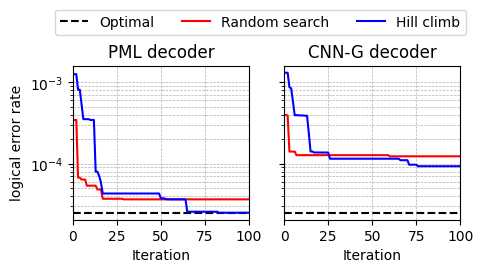

In [ ]:
import matplotlib.pyplot as plt

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2), sharey=True)

ax1.axhline(y=2.5E-5, color='k', linestyle='--', label='Optimal')
ax1.plot(jnp.arange(R_history_pml_3.shape[0])+1, R_history_pml_3, linestyle='-', color='r', label='Random search')
ax1.plot(jnp.arange(HC_history_pml_3.shape[0])+1, HC_history_pml_3, linestyle='-', color='b', label='Hill climb')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logical error rate')
ax1.set_title('PML decoder')
ax1.set_yscale('log')  # Log scale for better visualization
ax1.grid(True, which="both", linestyle='--', linewidth=0.5)
ax1.set_xlim(0, 100)

ax2.axhline(y=2.5E-5, color='k', linestyle='--', label='Optimal')
ax2.plot(jnp.arange(R_history_cnng_3.shape[0])+1, R_history_cnng_3, linestyle='-', color='r', label='Random search')
ax2.plot(jnp.arange(HC_history_cnng_3.shape[0])+1, HC_history_cnng_3, linestyle='-', color='b', label='Hill climb')
ax2.set_xlabel('Iteration')
ax2.set_title('CNN-G decoder')
ax2.set_yscale('log')  # Log scale for better visualization
ax2.grid(True, which="both", linestyle='--', linewidth=0.5)
ax2.set_xlim(0, 100)

# Add a common legend below the subplots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1))

plt.savefig("figs/hill_climb_vs_random_3.eps", dpi=300, bbox_inches='tight')
plt.savefig("figs/hill_climb_vs_random_3.pdf", dpi=300, bbox_inches='tight')
plt.savefig("figs/hill_climb_vs_random_3.png", dpi=300, bbox_inches='tight')

plt.show()